In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from collections import defaultdict
import os
import json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from src.dataset_handling import TextClassificationDataset
from src.utils import get_activations_and_labels, get_hidden_activations
from src.sparse_autoencoders import SAE_topk

In [3]:
model_url = "EleutherAI/pythia-14m"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'
layer = 3

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)

num_hookpoints = model.config.num_hidden_layers
hookpoint = hookpoint_name.replace('$', str(layer))
input_size = model.config.intermediate_size

data_path = 'data/split/tedtalks_test.tsv'
dataset = TextClassificationDataset.from_tsv(data_path)

In [4]:
hidden_acts_outfolder = 'results/sparse_autoencoder_activations'

In [5]:
expansion_factor = 4
k = 20

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': k
}

sae = SAE_topk(meta_data=meta_data)

sae.load_state_dict(torch.load(f'models/sparse_autoencoders/pythia-14m/topk{k}/{hookpoint}.pt', weights_only=True))

<All keys matched successfully>

In [6]:
da_acts = []
da_preacts = []
da_tokens = []
en_acts = []
en_preacts = []
en_tokens = []

for i in range(100):

    sent, label = dataset[i]

    tokenized = [
        tokenizer(input_, return_tensors='pt').to(device)
        for input_ in [sent]
    ]

    transformer_acts = get_hidden_activations(model, hookpoint, tokenized)

    sae_preacts = sae.get_preacts(transformer_acts)
    sae_acts = sae.get_activations(transformer_acts)

    for act_indices, preacts, token in zip(sae_acts.indices, sae_preacts, tokenized[0]['input_ids'][0]):

        zeros = torch.zeros(input_size * expansion_factor)

        zeros[act_indices] = 1

        if label == 0:
            da_acts.append(zeros)
            da_preacts.append(preacts)
            da_tokens.append(token.item())
        else:
            en_acts.append(zeros)
            en_preacts.append(preacts)
            en_tokens.append(token.item())

In [7]:
da_word_init_acts = []
da_word_init_preacts = []

for token, acts, preacts in zip(da_tokens, da_acts, da_preacts):
    if tokenizer.convert_ids_to_tokens(token).startswith('Ġ'):
        da_word_init_acts.append(acts)
        da_word_init_preacts.append(preacts)
    

en_word_init_acts = []
en_word_init_preacts = []

for token, acts, preacts in zip(en_tokens, en_acts, en_preacts):
    if tokenizer.convert_ids_to_tokens(token).startswith('Ġ'):
        en_word_init_acts.append(acts)
        en_word_init_preacts.append(preacts)

In [8]:
## TEXT PRINTING

def format_chars(text):
    formatted = (
        text.replace('Ġ', ' ').
            replace('Ã¥', 'å').
            replace('Ã¦', 'æ').
            replace('Ã¸', 'ø')
    )
    return formatted


# absolute genius stuff form chatgpt

def rgb_text(text, r, g, b, background=False):
    """Returns text formatted with 24-bit RGB color."""
    if background:
        if (r + g + b) / 3 > 128:
            return f"\033[38;2;0;0;0m\033[48;2;{r};{g};{b}m{text}\033[0m" 
        else:
            return f"\033[48;2;{r};{g};{b}m{text}\033[0m"
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [24]:
neuron = 398

def print_colored(tokens, preacts, neuron, tokenizer, stop_after=100):
    for idx, (token, preact) in enumerate(zip(tokens, preacts)):
        if idx == stop_after:
            break
        if idx % 20 == 0:
            print('')
        min_preact = min(preact).item()
        max_preact = max(preact).item()
        formatted = format_chars(tokenizer.convert_ids_to_tokens(token))
        value = (preact[neuron].item() - min_preact) / (max_preact - min_preact)
        #print(value * 255)
        print(rgb_text(formatted, r=int(value * 255), g=0, b=0, background=True), end='')


print_colored(en_tokens, en_preacts, 398, tokenizer)


TSA âĢĶ thousands standing around. No one's really going to bother you. "" So one
 of the things that I do is I actually look through my server logs very carefully. We have
 satellite maps where we can see where people are and where they're moving. Now the really interesting
 thing about these reactors is they're built in a factory. (Laughter) Along the way
, you lost something. On the evening of the 26th of August, 1928, May Don

In [27]:
threshold = -1

In [28]:
for token, acts in zip(en_tokens, en_preacts):
    if not acts[398] > threshold:
        print(tokenizer.convert_ids_to_tokens(token).
              replace('Ġ', ' ').
              replace('Ã¥', 'å').
              replace('Ã¦', 'æ').
              replace('Ã¸', 'ø'))

 standing
 really
 going
 bother
 look
 very
.
 and
 really
 built
.
 lost
.
 east
 and
 ice
 ice
.
standing
 pro
ver
.
 crafting
 story
 true
 chart
 and
 discovered
 out
,
 but
 left
.
 
:
 penalty
 points
 go
 crow
 ""
 going
 better
.
 ""
 war
 and
 performance
enh
 and
 healthy
 
 doing
 really
 important
 astr
 pointed
 in
 seeing
 ice
 melted
 going
 kill
.
 shot
 and
 confirmed
 Type
.
;
 toss
 grat
 too
)
 better
 palp
 going
 humor
 shots
 state
.
 
 pulling
 differences
.
 deep
 true
 affected
.
.
 out
.
 yielding
 since
 began
 leave
 fossil
.
 
.
 sign
 road
 driving
.
 cor
 begin
 told
.
 
 increase
 experienced
 since
 
urns
 in
 very
 strong
 day
,
 but
 is
 and
,
.
 fascinating
 catch
 and
 wind
 only
 bl
 and
 bru
ises
;
 try
 save
 standing
;
 fill
 rain
 up
 disappointment
.
 
 blow
 found
 intro
 deliver
 better
 outcomes
 ext
,
 managing
 proactive
 to
 run
,
 unw
 excited
 that
 stamp
 and
 bubble
.
 
 expectancy
 freezing
 in
.
 points
,
 and
 works
 beautifully

In [125]:
for token, acts in zip(en_tokens, en_preacts):
    if acts[398] > threshold:
        print(tokenizer.convert_ids_to_tokens(token).
              replace('Ġ', ' ').
              replace('Ã¥', 'å').
              replace('Ã¦', 'æ').
              replace('Ã¸', 'ø'))

T
SA
.
No
.
 the
We
.
Now
 the
(
 the
On
 the
I
 the
Good
It
's
 the
T
 little
 detail
A
 can
.
The
 the
That
.
How
Then
 people
 that
.
The
 the
Stand
,
We
 the
Because
 the
So
,
 the
On
th
 the
They
 the
To
But
 the
I
 perc
 the
So
 what
's
That
's
 the
Here
 you
 the
And
 we
 will
 the
So
 the
Yes
So
,
.
I
 the
And
 very
 the
We
It
's
Now
,
 three
,
We
 the
How
 could
 we
 the
That
's
T
 the
The
When
 the
And
 even
Your
And
 the
This
But
 the
They
 the
But
It
 can
We
We
 that
J
:
You
 the
Even
 my
Even
On
 the
It


In [99]:
avg_da = sum(da_acts) / len(da_acts)
avg_en = sum(en_acts) / len(en_acts)

avg_word_init_da = sum(da_word_init_acts) / len(da_word_init_acts)
avg_word_init_en = sum(en_word_init_acts) / len(en_word_init_acts)

In [12]:
if not os.path.isdir(f'{hidden_acts_outfolder}'):
    os.mkdir(f'{hidden_acts_outfolder}')

if not os.path.isdir(f'{hidden_acts_outfolder}/{model_name}'):
    os.mkdir(f'{hidden_acts_outfolder}/{model_name}')

df = pd.DataFrame({'avg_da': avg_da.numpy(), 'avg_en': avg_en.numpy()})
df.to_csv(f'{hidden_acts_outfolder}/{model_name}/{hookpoint}.csv', index=False)

In [94]:
max_diff_neuron = torch.argmax(avg_da - avg_en)

In [105]:
torch.where(avg_da - avg_en > 0.2)

(tensor([ 328,  398, 1090, 1097, 1184, 1787, 1871]),)

In [100]:
sorted(avg_da - avg_en, reverse=True)

[tensor(0.2732),
 tensor(0.2668),
 tensor(0.2632),
 tensor(0.2393),
 tensor(0.2180),
 tensor(0.2149),
 tensor(0.2065),
 tensor(0.1849),
 tensor(0.1834),
 tensor(0.1789),
 tensor(0.1748),
 tensor(0.1744),
 tensor(0.1694),
 tensor(0.1652),
 tensor(0.1586),
 tensor(0.1523),
 tensor(0.1505),
 tensor(0.1495),
 tensor(0.1488),
 tensor(0.1463),
 tensor(0.1430),
 tensor(0.1377),
 tensor(0.1371),
 tensor(0.1314),
 tensor(0.1176),
 tensor(0.1155),
 tensor(0.1153),
 tensor(0.1149),
 tensor(0.1138),
 tensor(0.1124),
 tensor(0.1120),
 tensor(0.1106),
 tensor(0.1068),
 tensor(0.0949),
 tensor(0.0942),
 tensor(0.0937),
 tensor(0.0930),
 tensor(0.0918),
 tensor(0.0917),
 tensor(0.0907),
 tensor(0.0888),
 tensor(0.0864),
 tensor(0.0863),
 tensor(0.0844),
 tensor(0.0839),
 tensor(0.0831),
 tensor(0.0808),
 tensor(0.0800),
 tensor(0.0780),
 tensor(0.0775),
 tensor(0.0773),
 tensor(0.0748),
 tensor(0.0734),
 tensor(0.0724),
 tensor(0.0705),
 tensor(0.0681),
 tensor(0.0679),
 tensor(0.0663),
 tensor(0.0651

In [96]:
(avg_da - avg_en)[max_diff_neuron]

tensor(0.4672)

In [106]:
da_preacts_tnsr = torch.stack(da_preacts).detach()
en_preacts_tnsr = torch.stack(en_preacts).detach()

In [90]:
def plot_difference_by_neuron(da_preacts, en_preacts, neuron):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_title(f'Neuron {neuron}')
    ax.hist(da_preacts[:, neuron], bins=30, alpha=0.5, color='blue')
    ax.hist(en_preacts[:, neuron], bins=30, alpha=0.5, color='orange')

    fig.tight_layout()
    fig.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_21004\2055940904.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


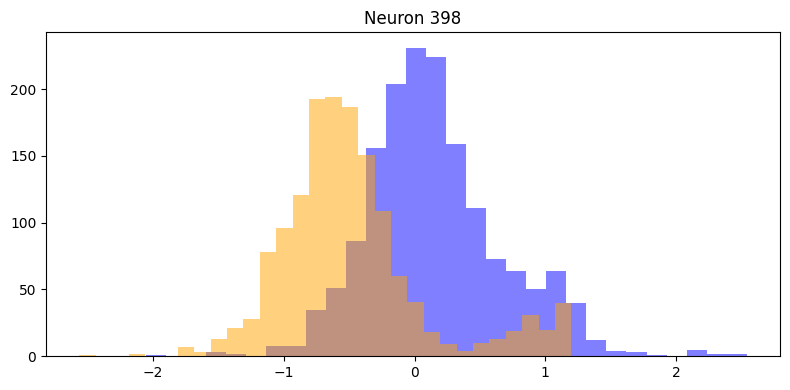

In [119]:
plot_difference_by_neuron(da_preacts_tnsr, en_preacts_tnsr, 398)